# A First Taste of Machine Learning

Notes on Chapter 1 of the above book by Terence Parr and Jeremy Howard. The book is a work in progress, so there will be changes in future.

Chapter 1 introduces a task: Predict the rent of an apartment in NYC given the number of bedrooms, bathroom, and the location (latitude and longitude).

Discusses decision tree and random forest models.

- How to train a model on the data.
- How to test the trained model with the trained data.
- How to improve the trained model.

- How to validate the model using testing data.<br> - split data <br>- _k_-fold cross validation

- How to compare the performance of one model compared to another. <br> - e.g. random forest vs linear regression vs gradient boosting

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [67]:
import pandas as pd
import scipy
import numpy

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

import matplotlib
from matplotlib.offsetbox import AnchoredText
from matplotlib import rc, rcParams
labelSize = 8
matplotlib.rcParams['xtick.labelsize'] = labelSize
matplotlib.rcParams['ytick.labelsize'] = labelSize
plt.style.use('ggplot')

## The Data

We are looking at four features of NYC apartments (number of bedrooms, number of bathroom, latitude and longitude) and their subsequent rents.

In [3]:
df = pd.read_csv('data/rent-ideal.csv')

In [4]:
df.head()

,bedrooms,bathrooms,latitude,longitude,price
0,3,1.5,40.7145,-73.9425,3000
1,2,1.0,40.7947,-73.9667,5465
2,1,1.0,40.7388,-74.0018,2850
3,1,1.0,40.7539,-73.9677,3275
4,4,1.0,40.8241,-73.9493,3350


In [5]:
df.shape

(48266, 5)

In [6]:
df.isnull().sum()

bedrooms     0
bathrooms    0
latitude     0
longitude    0
price        0
dtype: int64

In [7]:
df.dtypes

bedrooms       int64
bathrooms    float64
latitude     float64
longitude    float64
price          int64
dtype: object

In [8]:
# Group the data by number of bathrooms and take the mean of the other features.
bybaths = df.groupby(['bathrooms']).mean()

In [26]:
bybaths = bybaths.reset_index() # overcome quirk in Pandas
bybaths[['bathrooms','price']]

,bathrooms,price
0,0.0,3144.870000
1,1.0,3028.111035
2,1.5,4226.336449
3,2.0,5278.595739
4,2.5,6869.047368
5,3.0,6897.974576
6,3.5,7635.357143
7,4.0,7422.888889
8,4.5,2050.000000
9,10.0,3600.000000


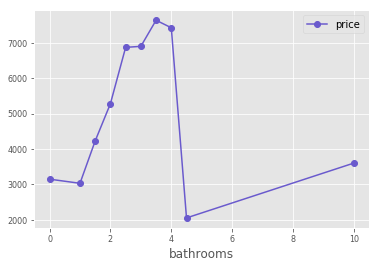

In [20]:
bybaths.plot.line('bathrooms','price',color='slateblue',style='-o')
plt.show()

## Training a Random Forest

Double square brackets will return a column as a data frame.
Single square brackets will return a column as a series.

In [29]:
# Get the features (the predictors) and the target values.
X, y = df[['bathrooms']], df['price']

In [30]:
# Train a random forest on the apartment data.
rf = RandomForestRegressor()
rf.fit(X,y)  # prettier way of calling a function and a method inside it

Now we can make a prediction with one or more feature vectors.

In [32]:
rf.predict([[0],[1]])

array([3140.98233638, 3029.57991952])

We now have the predicted prices for apartments with 0 bathrooms and 1 bathroom, respectively. Although it seems a bit weird for a 0-bath apartment to be more expensive than a 1-bath, this is what the plotted data shows. So, seems like the model has captured the underlying relationship between bathrooms and prices in the training data.

## Testing the Model

First, we verify that the model fits the training data well. So, does the model accurately capture the relationship between features and target values?

We verify by passing the feature vectors of the training data back into the model and compare the predictions with the actual target values.

In [41]:
# Feed the data back into the model. Here it's just the number of bathrooms b/c that's what we trained the model on.
predictions = rf.predict(X)

#### Mean Absolute Error (an error metric)

Now we need to measure the error between our predictions and the actual data. Here we'll compute the difference in price prediction and actual price for each apartment in the training data, take the absolute value of the difference, and calculate the mean of all of the difference values.

In [44]:
err = mean_absolute_error(y, predictions)
print(f'{err:.0f} average error; {err*100./y.mean():.2f} % error')

808 average error; 23.48 % error


## Improving the Model

We have trained the model using just one feature, number of bathrooms. We can improve the prediction accuracy of our model by including more features. So, let's train on number of bathrooms and bedrooms.

In [46]:
X, y = df[['bathrooms','bedrooms']], df['price']

rf = RandomForestRegressor()
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

And once again, we'll see how well our model does.

In [47]:
predictions = rf.predict(X)
err = mean_absolute_error(y, predictions)
print(f'{err:.0f} average error; {err*100./y.mean():.2f} % error')

723 average error; 21.01 % error


We have an improvement in prediction. 808 - 723 = \$86 or around a 10\% improvement. Not a huge improvement so this hints that bedrooms may not be as important of a predictor as bathrooms.

Let's see if we can do even better by just using location information.

In [48]:
X, y = df[['latitude','longitude']], df['price']

rf = RandomForestRegressor()
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [49]:
predictions = rf.predict(X)
err = mean_absolute_error(y, predictions)
print(f'{err:.0f} average error; {err*100./y.mean():.2f} % error')

523 average error; 15.21 % error


One may think that the improvement in error between bed/bath and lat/long is only 21-15=6\%. 

It's better to think of the ratio 15/21=71\% which tells us that our prediction error relative to the average rent price got 100-71=29\% better.


Great! Now let's see what how including all 4 predictors performs.

In [51]:
X, y = df[['bedrooms','bathrooms','latitude','longitude']], df['price']
rf = RandomForestRegressor()
rf.fit(X, y)
e = mean_absolute_error(y, rf.predict(X))
print(f"${e:.0f} average error; {e*100.0/y.mean():.2f}% error")

$189 average error; 5.51% error


Pretty darn good. But don't get too excited. This just tells us that our model has captured the relationships in the training data rather well. The true mark of a good model is to determine its performance on test data not yet seen.

## Model Validation

Two common ways to measure the success of a model is to validate by (1) splitting the data into a training set and a test/validation set (e.g. 20\% testing and 80\% training) and (2) k-fold cross validation.

### Split Data Validation
Let's start with splitting the data into two sets.

In [55]:
X, y = df[['bedrooms','bathrooms','latitude','longitude']], df['price']

# 80% of the data is for training and 20% is for validating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fit the training data.
rf = RandomForestRegressor()
rf.fit(X_train,y_train)

# How does the trained model perform on the test set?
e = mean_absolute_error(y_test, rf.predict(X_test))
print(f"${e:.0f} average error; {e*100.0/y.mean():.2f}% error")

err = mean_absolute_error(y_train, rf.predict(X_train))
print(f'${err:.0f} average error; {err*100./y.mean():.2f} % error')

$302 average error; 8.77% error
$190 average error; 5.53 % error


We see that the model performs about 1/3 better on the training set than on the test set. Although this is to be expected, we want the validation error to be as close to the training error as possible.

### k-fold Cross Validation

Running the split data validation code several times will produce different results with each run due to the randomness with which the data are selected for each set. We want to mitigate this.

_k_-fold cross validation repeats the split data validation _k_ times and takes the averages of the _k_ errors to get a final estimate of the validation error. The original data set is split into _k_ equally sized subsets and trains on _k_-1 subsets. The remaining subset is used to test the model.

E.g. for _k_=5, 5 subsets are created, the model is trained on subsets 1 through 4, tested on subset 5, and an error is computed. This method is repeated, this time training on subsets 2-5 and tested on subset 1. This continues until all subsets have been used as a training set. The average error from each of these iterations is the final error.

In [57]:
k = 5
cv_err = cross_val_score(RandomForestRegressor(),
                         X, y, cv=k,
                         scoring='neg_mean_absolute_error',
                         n_jobs=-1)
m_err = -cv_err.mean()
std_err = cv_err.std()
print(f"${m_err:.0f} average error +/-${2*std_err:.2f}; {m_err*100.0/y.mean():.2f}% error")

$306 average error +/-$15.87; 8.91% error


In [61]:
# Function to perform cross-validation.
def validate(model):
    cv_err = cross_val_score(model, X, y, cv=5, n_jobs=-1,
                             scoring='neg_mean_absolute_error')
    m_err = -cv_err.mean()
    std_err = cv_err.std()
    print(f"${m_err:.0f} average error +/-${2*std_err:.2f}; {m_err*100.0/y.mean():.2f}% error")

In [60]:
# Let's try increasing the number of decision trees from the default of 10 to 100.
rf = RandomForestRegressor(n_estimators=100)
validate(rf)

$299 average error +/-$15.51; 8.70% error


## How to determine which features have the most predictive power?

To compute such feature importance, we can compare the validation errors from a model trained using all features and the same model trained with a single feature removed. This difference tells us something about the relative importance of that missing feature. If the validation error goes way up, we know that feature is important. But if the error stays about the same, we can conclude that feature, in isolation, has very little predictive power.

This brute force retraining method works and illustrates the idea, but it's more efficient to randomize a feature's column and retest rather than removing and retraining the model. Here's how to print out feature importances with a little help from the `rfpimp` package:

In [63]:
from rfpimp import *
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X, y)
I = importances(rf, X, y)
I

,Importance
Feature,
longitude,0.624722
bedrooms,0.613327
latitude,0.562636
bathrooms,0.492612


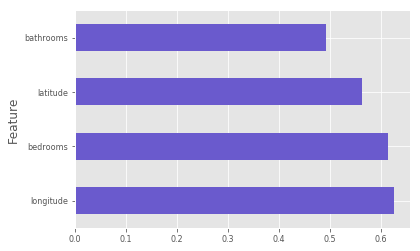

In [65]:
I.plot(kind='barh',legend=False,color='slateblue')

## Comparing Different Models

In [66]:
# Linear regression
lm = linear_model.LinearRegression() # create linear model
lm.fit(X, y)
validate(lm)

$658 average error +/-$12.66; 19.14% error


Ouch, the error of the linear model, 19\%, is more than twice that of the random forest model, 8.7\%.

In [69]:
# Gradient Boosting
gbr = GradientBoostingRegressor() # create boosting model
gbr.fit(X_train, y_train)
validate(gbr)

$518 average error +/-$7.17; 15.06% error
